In [3]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime

sys.path.append(os.path.abspath("D:\\burtm\\Visual_studio_code\\PD_related_projects"))

from utils.model_utils import get_model, get_trainable_layers
from utils.data_loading import get_dataloaders
from utils.utils_transforms import get_transform  
from utils.training_utils import fine_tune_last_n_layers, train_model, get_criterion, get_optimizer, get_scheduler

KeyboardInterrupt: 

In [7]:
import accelerate
import peft
import bitsandbytes

In [8]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, PreTrainedModel, PretrainedConfig
from PIL import Image
import requests

# load image from the IAM database
'''url = 'https://fki.tic.heia-fr.ch/static/img/a01-122-02-00.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")'''
# Select one word image from the word_images list

#processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-handwritten')
#processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-handwritten',force_download=True) #force download clear the cache and redownload the model
#processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-handwritten',use_fast=False)
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-stage1',use_fast=False)

In [2]:
#model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-stage1')

NameError: name 'VisionEncoderDecoderModel' is not defined

In [22]:
print(model)

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense):

import cv2
image = cv2.imread("D:\\burtm\\Visual_studio_code\\PD_related_projects\\4-terrapins.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
pixel_values = processor(images=image, return_tensors="pt").pixel_values

outputs = model.encoder(pixel_values=pixel_values)
last_hidden_state = outputs.last_hidden_state
print("Last hidden state shape:", last_hidden_state.shape)
patch_size = model.encoder.config.patch_size  # e.g., 16
image_size = model.encoder.config.image_size  # e.g., 224

num_patches = (image_size // patch_size) ** 2
print(num_patches)

In [1]:
print(model.encoder)

NameError: name 'model' is not defined

In [ ]:
# Define the classifier model
class Classifier(nn.Module):
    def __init__(self, encoder, num_classes=2):
        super(Classifier, self).__init__()
        self.encoder = encoder
        self.classification_head = nn.Linear(encoder.config.hidden_size, num_classes)

    def forward(self, pixel_values):
        outputs = self.encoder(pixel_values=pixel_values)
        cls_token_output = outputs.last_hidden_state[:, 0, :]  # Extract the CLS token
        logits = self.classification_head(cls_token_output)
        return logits

# Define the classifier model
class FullClassifier(nn.Module):
    def __init__(self, encoder, hidden_size, num_classes=2):
        super(FullClassifier, self).__init__()
        self.encoder = encoder
        self.classification_head = nn.Sequential(
            nn.Linear(hidden_size, 128),  # Hidden size of encoder output
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, pixel_values):
        outputs = self.encoder(pixel_values=pixel_values)
        #cls_token_output = outputs.last_hidden_state[:, 0, :]  # Extract the CLS token
        mean_pooled = outputs.last_hidden_state.mean(dim=1)
        logits = self.classification_head(mean_pooled)
        return logits

# Create the classifier model
#model = Classifier(model.encoder)
# Define the model
hidden_size = model.encoder.config.hidden_size  
print("Hidden size:", hidden_size)
num_classes = 2  # Example: binary classification
model = FullClassifier(model.encoder,hidden_size, num_classes)


In [9]:
#selected_model = "trocr-handwriting-small"
selected_model = "trocr-small-stage1"
selected_transform = "Deit"
N_max=282
use_patches=True
pretrained=True
depth=1
num_epochs=10
batch_size=32
learning_rate=0.001
input_filename="icdar_train_df_patches_cc.csv"
criterion_name="CrossEntropyLoss"
criterion = get_criterion("CrossEntropyLoss")
optimizer_name = "Adam"
num_classes = 2  # Change this to match your dataset
early_stopping=10
scheduler_name = 'no_scheduling'#CosineAnnealingLR'
checkpoint_path = "D:\\burtm\Visual_studio_code\PD_related_projects\checkpoints\\"
models_path = "D:\\burtm\Visual_studio_code\PD_related_projects\outputs\models\\"

In [10]:
# Example training metadata
training_metadata = {
    "type_of_approach": "finetuning the encoder (DEIT) of trocr models; parameter efficient fine tuning with adapters",
    "type_of_approach_sigla": "DEIT-finetuning",
    "model_name": selected_model,
    "transform_name": selected_transform,
    "epochs": num_epochs,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "optimizer": optimizer_name,
    "pretrained": pretrained,
    "depth": depth,
    "use_patches": use_patches,
    "input_filename": input_filename,
    "num_classes": num_classes,
    "criterion_name": criterion_name,
    "early_stopping": early_stopping,
    "N_max": N_max,
    "scheduler_name": scheduler_name,
}

# LoRA

In [69]:
class DeiTConfig(PretrainedConfig):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

class DeiTWrapper(PreTrainedModel):
    def __init__(self, config, base_model):
        super().__init__(config)
        self.base_model = base_model

    def forward(self, x, labels=None):
        logits = self.base_model(x)
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

In [70]:
# Prepare model config
config = DeiTConfig()

# Wrap
model = DeiTWrapper(config, model)

In [10]:
print([name for name, _ in model.named_modules()])

['', 'encoder', 'encoder.embeddings', 'encoder.embeddings.patch_embeddings', 'encoder.embeddings.patch_embeddings.projection', 'encoder.embeddings.dropout', 'encoder.encoder', 'encoder.encoder.layer', 'encoder.encoder.layer.0', 'encoder.encoder.layer.0.attention', 'encoder.encoder.layer.0.attention.attention', 'encoder.encoder.layer.0.attention.attention.query', 'encoder.encoder.layer.0.attention.attention.key', 'encoder.encoder.layer.0.attention.attention.value', 'encoder.encoder.layer.0.attention.attention.dropout', 'encoder.encoder.layer.0.attention.output', 'encoder.encoder.layer.0.attention.output.dense', 'encoder.encoder.layer.0.attention.output.dropout', 'encoder.encoder.layer.0.intermediate', 'encoder.encoder.layer.0.intermediate.dense', 'encoder.encoder.layer.0.intermediate.intermediate_act_fn', 'encoder.encoder.layer.0.output', 'encoder.encoder.layer.0.output.dense', 'encoder.encoder.layer.0.output.dropout', 'encoder.encoder.layer.0.layernorm_before', 'encoder.encoder.layer.0

In [102]:
from peft import get_peft_model, LoraConfig, TaskType

# Define LoRA config
lora_config = LoraConfig(
    #task_type=TaskType.FEATURE_EXTRACTION, #.SEQ_CLS, #FEATURE_EXTRACTION,  # use SEQ_CLS for classification #TOKEN_CLS
    #task_type=TaskType.CAUSAL_LM,  # <-- prevents input_ids expectation,
    r=8,  # rank of LoRA
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    target_modules=["query", "value"]
)

# This step requires adapting your model to integrate with PEFT
# Wrap the attention layers manually or use HuggingFace `transformers` if possible
model = get_peft_model(model, lora_config)

In [103]:
print(model)

PeftModel(
  (base_model): LoraModel(
    (model): Classifier(
      (encoder): DeiTModel(
        (embeddings): DeiTEmbeddings(
          (patch_embeddings): DeiTPatchEmbeddings(
            (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): DeiTEncoder(
          (layer): ModuleList(
            (0-11): 12 x DeiTLayer(
              (attention): DeiTSdpaAttention(
                (attention): DeiTSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=384, out_features=384, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=384, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
                   

In [95]:
model = Classifier(model)

In [43]:
print(model)

Classifier(
  (encoder): PeftModelForFeatureExtraction(
    (base_model): LoraModel(
      (model): DeiTModel(
        (embeddings): DeiTEmbeddings(
          (patch_embeddings): DeiTPatchEmbeddings(
            (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): DeiTEncoder(
          (layer): ModuleList(
            (0-11): 12 x DeiTLayer(
              (attention): DeiTSdpaAttention(
                (attention): DeiTSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=384, out_features=384, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=384, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(

In [104]:
for name, param in model.named_parameters():
    if not any(sub in name for sub in ["lora", "classification_head"]):
        param.requires_grad = False
    else:
        param.requires_grad = True

In [105]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.shape}")

base_model.model.encoder.encoder.layer.0.attention.attention.query.lora_A.default.weight: torch.Size([8, 384])
base_model.model.encoder.encoder.layer.0.attention.attention.query.lora_B.default.weight: torch.Size([384, 8])
base_model.model.encoder.encoder.layer.0.attention.attention.value.lora_A.default.weight: torch.Size([8, 384])
base_model.model.encoder.encoder.layer.0.attention.attention.value.lora_B.default.weight: torch.Size([384, 8])
base_model.model.encoder.encoder.layer.1.attention.attention.query.lora_A.default.weight: torch.Size([8, 384])
base_model.model.encoder.encoder.layer.1.attention.attention.query.lora_B.default.weight: torch.Size([384, 8])
base_model.model.encoder.encoder.layer.1.attention.attention.value.lora_A.default.weight: torch.Size([8, 384])
base_model.model.encoder.encoder.layer.1.attention.attention.value.lora_B.default.weight: torch.Size([384, 8])
base_model.model.encoder.encoder.layer.2.attention.attention.query.lora_A.default.weight: torch.Size([8, 384])
b

In [107]:
model.print_trainable_parameters()

trainable params: 148,226 || all params: 22,108,418 || trainable%: 0.6705


In [108]:
transform=processor
train_dataloader,val_dataloader=data_loading.get_dataloaders(transform, 
                                                             batch_size=batch_size, N_max=N_max, 
                                                             file_name=input_filename, hugging=True)

loaded train_df from: D:\burtm\Visual_studio_code\PD_related_projects\outputs\preprocessed_data\icdar_train_df_patches_cc.csv


In [109]:
optimizer = training_utils.get_optimizer(model, optimizer_name, lr=learning_rate)
scheduler = training_utils.get_scheduler(optimizer, scheduler_name, T_max=num_epochs)

In [110]:
# Define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is: ",device)
model = model.to(device)

Device is:  cuda


In [ ]:
#Profile with torch.utils.bottleneck or torch.profiler to see slow layers

In [111]:
start_time=datetime.now()
model,train_losses,val_losses = training_utils.train_model(model, train_dataloader, val_dataloader, criterion, optimizer, device, 
                                            num_epochs=num_epochs, 
                                            checkpoint_path=checkpoint_path,
                                            early_stopping_patience=early_stopping, scheduler=scheduler)
end_time=datetime.now()

Epoch 1/10: 100%|██████████| 80/80 [1:04:24<00:00, 48.31s/it]


Epoch 1, Train Loss: 0.6610, Train Acc: 0.5945
Epoch 1, Val Loss: 1.0187, Val Acc: 0.4448
Checkpoint saved: D:\burtm\Visual_studio_code\PD_related_projects\checkpoints\best_checkpoint.pth


Epoch 2/10:   0%|          | 0/80 [00:51<?, ?it/s]


KeyboardInterrupt: 

# adapters

It takes 20mins per epoch (16 seconds per iteration) with the adapter_size=32 applied to every mlp layer. Accuracy turns out to be 0.5, like random guessing 
-> probably some mistake in adding the adapters?

In [9]:
class Adapter(nn.Module):
    def __init__(self, hidden_size, adapter_size=32):
        super().__init__()
        self.down_proj = nn.Linear(hidden_size, adapter_size)
        self.activation = nn.ReLU()
        self.up_proj = nn.Linear(adapter_size, hidden_size)

    def forward(self, x):
        return x + self.up_proj(self.activation(self.down_proj(x)))


In [11]:
print(model)

Classifier(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_feat

In [28]:
# Find transformer blocks
#blocks = model.blocks  # For ViT/DeiT from timm
blocks = model.encoder.encoder.layer  # For HuggingFace ViT/DeiT
#hidden_size = model.embed_dim  # usually 768 for base models
hidden_size = 384

In [29]:
import types
for i, block in enumerate(blocks):
    adapter = Adapter(hidden_size)
    block.adapter = adapter  # attach to the block so it's part of the model
    
    # Save original MLP forward
    #original_mlp_forward = block.mlp.forward
    original_mlp_forward = block.output.forward  #check if the position is right by comparing where mlp is in the timm model

    # Redefine the mlp forward
    def new_mlp_forward(self, hidden_states, input_tensor):
        hidden_states = original_mlp_forward(hidden_states, input_tensor)
        hidden_states = self.adapter(hidden_states)
        return hidden_states

    # Bind the new forward to the mlp
    #block.mlp.forward = new_mlp_forward.__get__(block.mlp, block.mlp.__class__)
    #block.output.forward = new_mlp_forward.__get__(block.output, block.output.__class__)
    block.output.forward = types.MethodType(new_mlp_forward,block)

In [30]:
print(model)

Classifier(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_feat

In [31]:
for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if any(sub in name for sub in ["classification_head"]):
        param.requires_grad = True

for block in blocks:
    for param in block.adapter.parameters():
        param.requires_grad = True

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.shape}")


encoder.encoder.layer.0.adapter.down_proj.weight: torch.Size([32, 384])
encoder.encoder.layer.0.adapter.down_proj.bias: torch.Size([32])
encoder.encoder.layer.0.adapter.up_proj.weight: torch.Size([384, 32])
encoder.encoder.layer.0.adapter.up_proj.bias: torch.Size([384])
encoder.encoder.layer.1.adapter.down_proj.weight: torch.Size([32, 384])
encoder.encoder.layer.1.adapter.down_proj.bias: torch.Size([32])
encoder.encoder.layer.1.adapter.up_proj.weight: torch.Size([384, 32])
encoder.encoder.layer.1.adapter.up_proj.bias: torch.Size([384])
encoder.encoder.layer.2.adapter.down_proj.weight: torch.Size([32, 384])
encoder.encoder.layer.2.adapter.down_proj.bias: torch.Size([32])
encoder.encoder.layer.2.adapter.up_proj.weight: torch.Size([384, 32])
encoder.encoder.layer.2.adapter.up_proj.bias: torch.Size([384])
encoder.encoder.layer.3.adapter.down_proj.weight: torch.Size([32, 384])
encoder.encoder.layer.3.adapter.down_proj.bias: torch.Size([32])
encoder.encoder.layer.3.adapter.up_proj.weight: to

In [18]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {trainable_params}")

Total number of trainable parameters: 300674


In [19]:
#verify that works
out = model(torch.randn(1, 3, 224, 224))  # dummy input
loss = out.mean()
loss.backward()

RuntimeError: The size of tensor a (198) must match the size of tensor b (578) at non-singleton dimension 1

In [22]:
transform=processor
train_dataloader,val_dataloader=data_loading.get_dataloaders(transform, 
                                                             batch_size=batch_size, N_max=N_max, 
                                                             file_name=input_filename, hugging=True)

loaded train_df from: D:\burtm\Visual_studio_code\PD_related_projects\outputs\preprocessed_data\icdar_train_df_patches_cc.csv


In [32]:
optimizer = training_utils.get_optimizer(model, optimizer_name, lr=learning_rate)
scheduler = training_utils.get_scheduler(optimizer, scheduler_name, T_max=num_epochs)

In [33]:
# Define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is: ",device)
model = model.to(device)

Device is:  cuda


In [34]:
start_time=datetime.now()
model,train_losses,val_losses = training_utils.train_model(model, train_dataloader, val_dataloader, criterion, optimizer, device, 
                                            num_epochs=num_epochs, 
                                            checkpoint_path=checkpoint_path,
                                            early_stopping_patience=early_stopping, scheduler=scheduler)
end_time=datetime.now()

Epoch 1/10: 100%|██████████| 80/80 [21:30<00:00, 16.13s/it]


Epoch 1, Train Loss: 0.7447, Train Acc: 0.5087
Epoch 1, Val Loss: 0.6947, Val Acc: 0.4655
Checkpoint saved: D:\burtm\Visual_studio_code\PD_related_projects\checkpoints\best_checkpoint.pth


Epoch 2/10:   0%|          | 0/80 [00:07<?, ?it/s]


KeyboardInterrupt: 

# standard

how much time to fine tune the whole model? 60s per iteration -> 1h per epoch

In [13]:
transform=processor
train_dataloader,val_dataloader=data_loading.get_dataloaders(transform, 
                                                             batch_size=batch_size, N_max=N_max, 
                                                             file_name=input_filename, hugging=True)


loaded train_df from: D:\burtm\Visual_studio_code\PD_related_projects\outputs\preprocessed_data\icdar_train_df_patches_cc.csv


In [15]:
import random

train_iter = iter(train_dataloader)
random_batches = [next(train_iter) for _ in range(3)]

for batch_idx, batch in enumerate(random_batches):
    print(f"Batch {batch_idx + 1}:")
    labels = batch['label']  # Assuming the batch contains a 'labels' key
    writers = batch['writer']  # Assuming the batch contains a 'writers' key
    for i, (label, writer) in enumerate(zip(labels, writers)):
        print(f"  Element {i + 1}: Label = {label}, Writer = {writer}")

Batch 1:
  Element 1: Label = 0, Writer = 251
  Element 2: Label = 1, Writer = 123
  Element 3: Label = 1, Writer = 179
  Element 4: Label = 0, Writer = 277
  Element 5: Label = 0, Writer = 271
  Element 6: Label = 1, Writer = 105
  Element 7: Label = 1, Writer = 67
  Element 8: Label = 0, Writer = 200
  Element 9: Label = 0, Writer = 249
  Element 10: Label = 1, Writer = 36
  Element 11: Label = 0, Writer = 196
  Element 12: Label = 1, Writer = 240
  Element 13: Label = 0, Writer = 275
  Element 14: Label = 0, Writer = 47
  Element 15: Label = 0, Writer = 44
  Element 16: Label = 0, Writer = 225
  Element 17: Label = 1, Writer = 86
  Element 18: Label = 0, Writer = 237
  Element 19: Label = 0, Writer = 192
  Element 20: Label = 0, Writer = 68
  Element 21: Label = 1, Writer = 5
  Element 22: Label = 0, Writer = 243
  Element 23: Label = 1, Writer = 82
  Element 24: Label = 0, Writer = 204
  Element 25: Label = 0, Writer = 64
  Element 26: Label = 1, Writer = 195
  Element 27: Label = 

In [14]:
'''import pandas as pd
from PIL import Image
import numpy as np

# Load the CSV file
df = pd.read_csv("D:\\burtm\\Visual_studio_code\\PD_related_projects\\outputs\\preprocessed_data\\"+input_filename)

# Get the path of the first image
first_image_path = df.iloc[0]['file_name']

# Load the image
image = Image.open(first_image_path)

# Convert the image to a NumPy array
image_array = np.array(image)

# Print the max and min values
print("Max value:", image_array.max())
print("Min value:", image_array.min())'''

'import pandas as pd\nfrom PIL import Image\nimport numpy as np\n\n# Load the CSV file\ndf = pd.read_csv("D:\\burtm\\Visual_studio_code\\PD_related_projects\\outputs\\preprocessed_data\\"+input_filename)\n\n# Get the path of the first image\nfirst_image_path = df.iloc[0][\'file_name\']\n\n# Load the image\nimage = Image.open(first_image_path)\n\n# Convert the image to a NumPy array\nimage_array = np.array(image)\n\n# Print the max and min values\nprint("Max value:", image_array.max())\nprint("Min value:", image_array.min())'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.35686272..1.0].


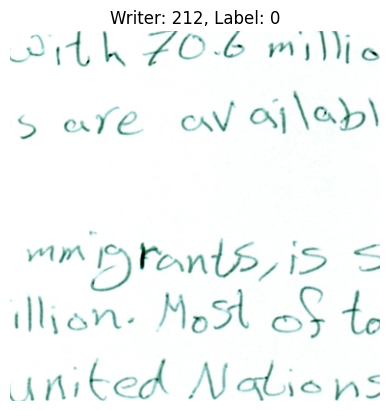

In [19]:
visualization.show_single_image(train_dataloader,index=111, save_path=None, from_dataloader=True)

In [11]:
print(processor)

TrOCRProcessor:
- image_processor: DeiTImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "DeiTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

- tokenizer: XLMRobertaTokenizer(name_or_path='microsoft/trocr-small-handwritten', vocab_size=64002, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=

In [39]:
# Define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is: ",device)
model = model.to(device)

Device is:  cuda


In [26]:
print(model)

Classifier(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_feat

In [41]:
layers=training_utils.get_all_layers(model)
print(len(layers))
n_layers=len(layers)
for i, layer in enumerate(layers):
    print(f"Layer {i}: {layer}")

150
Layer 0: Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
Layer 1: Dropout(p=0.0, inplace=False)
Layer 2: Linear(in_features=384, out_features=384, bias=True)
Layer 3: Linear(in_features=384, out_features=384, bias=True)
Layer 4: Linear(in_features=384, out_features=384, bias=True)
Layer 5: Dropout(p=0.0, inplace=False)
Layer 6: Linear(in_features=384, out_features=384, bias=True)
Layer 7: Dropout(p=0.0, inplace=False)
Layer 8: Linear(in_features=384, out_features=1536, bias=True)
Layer 9: GELUActivation()
Layer 10: Linear(in_features=1536, out_features=384, bias=True)
Layer 11: Dropout(p=0.0, inplace=False)
Layer 12: LayerNorm((384,), eps=1e-12, elementwise_affine=True)
Layer 13: LayerNorm((384,), eps=1e-12, elementwise_affine=True)
Layer 14: Linear(in_features=384, out_features=384, bias=True)
Layer 15: Linear(in_features=384, out_features=384, bias=True)
Layer 16: Linear(in_features=384, out_features=384, bias=True)
Layer 17: Dropout(p=0.0, inplace=False)
Layer 18: Linear(i

In [44]:
# Freeze all layers but the last n
num_trainable_layers = model_utils.get_trainable_layers(selected_model,depth=depth) 
#model = training_utils.fine_tune_last_n_layers(model, num_trainable_layers)
model = training_utils.fine_tune_last_n_layers(model, n_layers) #fine tune all parameters
#print(model)
optimizer = training_utils.get_optimizer(model, optimizer_name, lr=learning_rate)
scheduler = training_utils.get_scheduler(optimizer, scheduler_name, T_max=num_epochs)

Total Layers: 203
Total Parameters: 21,960,962
Trainable Parameters after freezing: 0


Unfreezing the following layers:
Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
Dropout(p=0.0, inplace=False)
Linear(in_features=384, out_features=384, bias=True)
Linear(in_features=384, out_features=384, bias=True)
Linear(in_features=384, out_features=384, bias=True)
Dropout(p=0.0, inplace=False)
Linear(in_features=384, out_features=384, bias=True)
Dropout(p=0.0, inplace=False)
Linear(in_features=384, out_features=1536, bias=True)
GELUActivation()
Linear(in_features=1536, out_features=384, bias=True)
Dropout(p=0.0, inplace=False)
LayerNorm((384,), eps=1e-12, elementwise_affine=True)
LayerNorm((384,), eps=1e-12, elementwise_affine=True)
Linear(in_features=384, out_features=384, bias=True)
Linear(in_features=384, out_features=384, bias=True)
Linear(in_features=384, out_features=384, bias=True)
Dropout(p=0.0, inplace=False)
Linear(in_features=384, out_features=384, bias=True)
Dropout(p=0.0, inp

In [45]:
start_time=datetime.now()
model,train_losses,val_losses = training_utils.train_model(model, train_dataloader, val_dataloader, criterion, optimizer, device, 
                                            num_epochs=num_epochs, 
                                            checkpoint_path=checkpoint_path,
                                            early_stopping_patience=early_stopping, scheduler=scheduler)
end_time=datetime.now()

Epoch 1/10:   1%|▏         | 1/80 [01:57<2:34:09, 117.08s/it]


KeyboardInterrupt: 

In [49]:
#get the best_checkpoint.pth and add the training metadata to it
checkpoint = torch.load(checkpoint_path+'best_checkpoint.pth',weights_only=False)
checkpoint['training_metadata'] = training_metadata
val_accuracy= checkpoint['val_acc']
# Save the updated checkpoint with metadata
torch.save(checkpoint, checkpoint_path+'best_checkpoint.pth')

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
torch.save(checkpoint, f"{models_path}\{training_metadata['type_of_approach_sigla']}_ValAcc{val_accuracy}_{timestamp}.pth")


In [ ]:
#do the same for the last checkpoint
checkpoint = torch.load(checkpoint_path+'last_checkpoint.pth',weights_only=False)
checkpoint['training_metadata'] = training_metadata
# Save the updated checkpoint with metadata
torch.save(checkpoint, checkpoint_path+'last_checkpoint.pth')

# easy access

In [12]:
def reload_modules():
    import importlib
    import utils.data_loading as data_loading
    import utils.visualization as visualization
    import utils.dataframes as dataframes
    import utils.utils_transforms as u_transforms
    import utils.training_utils as training_utils
    import utils.model_utils as model_utils
    

    importlib.reload(data_loading)
    importlib.reload(visualization)
    importlib.reload(dataframes)
    importlib.reload(u_transforms)
    importlib.reload(model_utils)
    importlib.reload(training_utils)

    return data_loading, visualization, dataframes, u_transforms, training_utils, model_utils
data_loading, visualization, dataframes, u_transforms, training_utils, model_utils = reload_modules()